In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from deepthink.optimizers import Adam
from deepthink.layers import Dense
from deepthink.model import Model
from deepthink.activations import ReLU,  Sigmoid
from deepthink.loss import MeanSquaredError

# Set default matplotlib style
plt.style.use('ggplot')

## House price regression example

The purpose of this notebook is to demonstrate how to train a model on a regression task. The dataset used is the California Housing Prices dataset from the StatLib repository ([see this link for more info](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)) which can be downloaded from [here](https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv). This is a dataset of house prices from the 1990 California census and the objective is to predict the house price given several other features.

For this notebook I have taken inspiration from Chaper 2 of the excellent book ["Hands-On Machine Learning with Scikit-Learn and TensorFlow"](https://www.amazon.co.uk/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1098125975) by Aurélien Géron. I would strongly recommend this book to beginners looking to learn machine learning. It's also a great reference point for experienced machine learning practitioners.

The goal of this notebook is to demonstrate functionally on a regression task, not to set state-of-the-art results. I have therefore spent minimal time cleaning the data, feature selection, etc. For a more detailed look I would refer the reader to Chaper 2 of Hands-On Machine Learning with Scikit-Learn and TensorFlow.

## Loading the data

The function will below will download the dataset and save it if does not already exist. Subsequent calls will load the dataset from the local machine. 

In [2]:
def load_housing_data(filepath=None):
    """
    Load California Housing dataset.

    It will download the dataset if it does not already exist and then
    subsequent calls will load from the local machine.

    Parameters
    ----------
    filepath : str
        The location to save/load the dataset.

    References
    ----------
    - https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html
    """
    url = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv'
    if filepath:
        if os.path.exists(filepath):
            df = pd.read_csv(filepath)
        else:
            print('Downloading dataset...')
            df = pd.read_csv(url)
            df.to_csv(filepath, index=False)
    else:
        print('Downloading dataset...')
        df = pd.read_csv(url)

    return df

In [3]:
df = load_housing_data('../Data/CaliforniaHousing.csv')

n_samples, n_feats = df.shape
print(f'Dataset has {n_samples} samples and {n_feats} features.')

Dataset has 20640 samples and 10 features.


In [4]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
# Drop rows with NaNs
df = df[~df.isnull().any(axis=1)]

# Drop categorical column
df.drop(columns=['ocean_proximity'], inplace=True)

# Create new features
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

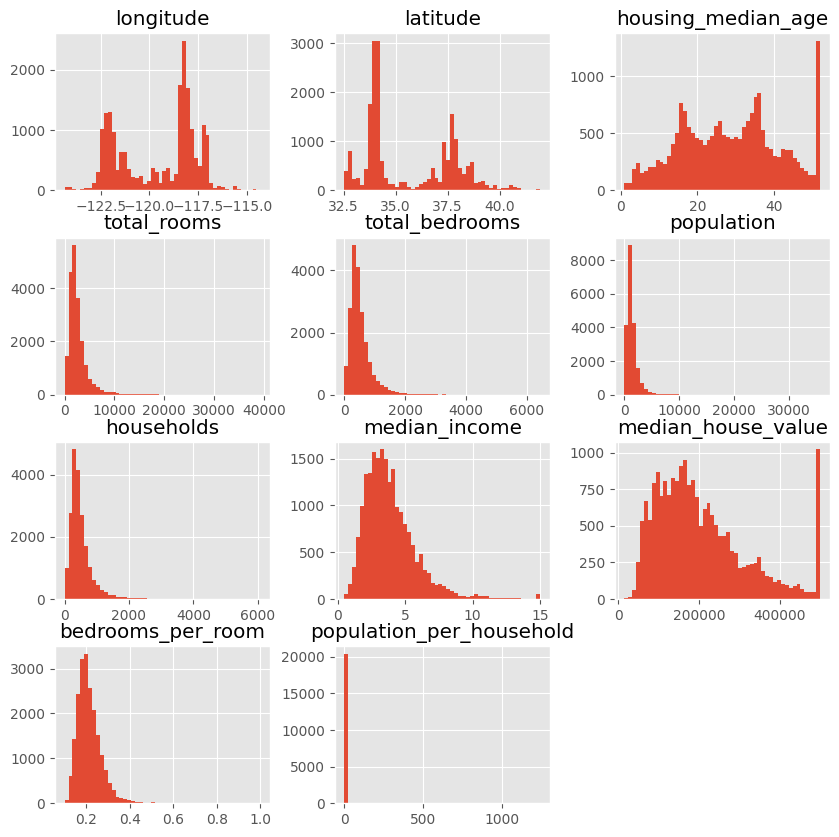

In [6]:
# Use histogram to visualize distributions
df.hist(bins=50, figsize=(10, 10))

plt.show()

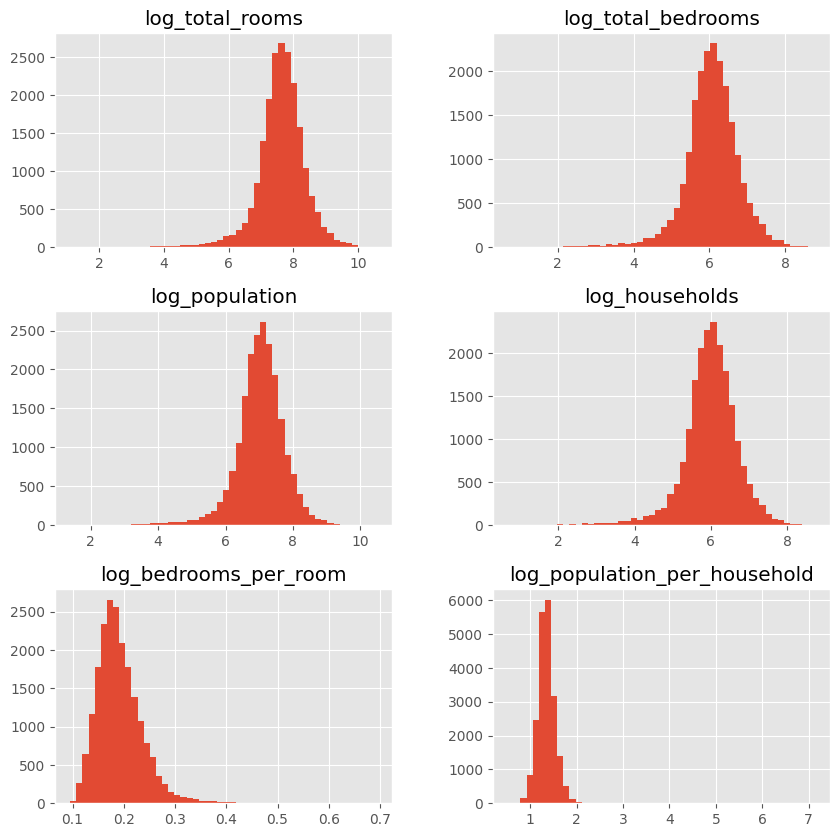

In [7]:
# Log-transform skewed columns
log_cols = ['total_rooms', 'total_bedrooms', 'population', 'households',
            'bedrooms_per_room', 'population_per_household']

for col in log_cols:
    df[f'log_{col}'] = df[col].apply(np.log1p)

# View histograms of the log-transformed columns
new_cols = df.columns[df.columns.str.startswith('log')]
df[new_cols].hist(bins=50, figsize=(10, 10))
plt.show()

In [8]:
df.corr()['median_house_value'].sort_values(ascending=False)

median_house_value              1.000000
median_income                   0.688355
log_total_rooms                 0.158506
total_rooms                     0.133294
housing_median_age              0.106432
log_households                  0.072765
households                      0.064894
log_total_bedrooms              0.053311
total_bedrooms                  0.049686
log_population                 -0.021904
population_per_household       -0.023639
population                     -0.025300
longitude                      -0.045398
latitude                       -0.144638
log_population_per_household   -0.246415
bedrooms_per_room              -0.255880
log_bedrooms_per_room          -0.271949
Name: median_house_value, dtype: float64

In [9]:
# Normalize data
# store target min and max for reversing process
target_min = df['median_house_value'].min()
target_max = df['median_house_value'].max()
df = (df - df.min()) / (df.max() - df.min())

In [10]:
feature_cols = ['median_income', 'log_bedrooms_per_room', 'latitude',
                'longitude', 'log_population_per_household',
                'housing_median_age']
df[feature_cols].corr()

,median_income,log_bedrooms_per_room,latitude,longitude,log_population_per_household,housing_median_age
median_income,1.000000,-0.639181,-0.079626,-0.015550,-0.029493,-0.118278
log_bedrooms_per_room,-0.639181,1.000000,-0.113675,0.093296,-0.038605,0.140446
latitude,-0.079626,-0.113675,1.000000,-0.924616,-0.132598,0.011899
longitude,-0.015550,0.093296,-0.924616,1.000000,0.144243,-0.109357
log_population_per_household,-0.029493,-0.038605,-0.132598,0.144243,1.000000,-0.007336
housing_median_age,-0.118278,0.140446,0.011899,-0.109357,-0.007336,1.000000


In [11]:
# Convert DataFrame to Numpy arrays
X_data = df[feature_cols].values
# y-data reshaped to column array from 1D
y_data = df['median_house_value'].values.reshape(-1, 1)

In [12]:
# Splitting into training & test data
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                    y_data,
                                                    test_size=0.25)
print(X_train.shape, X_test.shape)

(15324, 6) (5109, 6)


In [13]:
# Define hyperparameters
input_dims = X_train.shape[1]
learning_rate = 0.001
batch_size = 128
init_type = 'he_uniform'

In [14]:
# Building the model
opt = Adam(learning_rate)
model = Model(opt, cost=MeanSquaredError(),
              batch_size=batch_size,
              metrics=['RMSE'])
model.add_layer(Dense(32, n_inputs=input_dims,
                      weight_init=init_type))
model.add_layer(ReLU())
model.add_layer(Dense(32, weight_init=init_type))
model.add_layer(ReLU())
model.add_layer(Dense(1, weight_init=init_type))
model.add_layer(Sigmoid())

model.initialize()

In [15]:
model.summary()

Model summary:
_________________________________________________________________
Layer Type                 Output Shape                   Param #
Dense Layer               (None, 32)                          192
ReLU Activation           (None, 32)                            0
Dense Layer               (None, 32)                         1024
ReLU Activation           (None, 32)                            0
Dense Layer               (None, 1)                            32
Sigmoid Activation        (None, 1)                             0
Total params: 1,313


In [16]:
history = model.train((X_train, y_train), (X_test, y_test),
                      epochs=100, verbose=False)

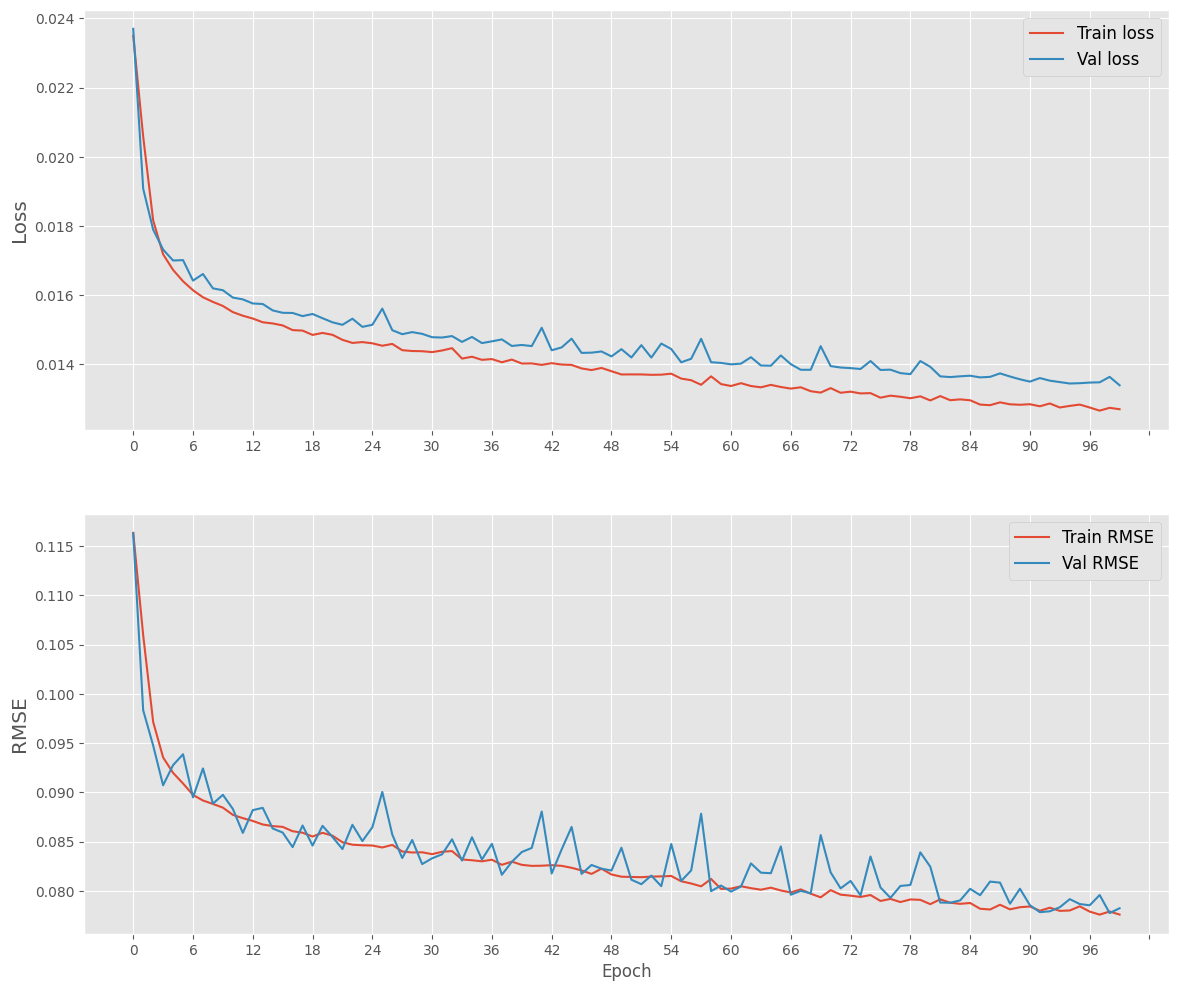

In [17]:
history.plot_history()

In [18]:
# Evaluate model performance
best_epoch = np.argmin(history.history['val_loss'])
min_loss = history.history['val_loss'][best_epoch]
min_rmse = history.history['RMSE'][best_epoch]

print(f'Best epoch: {best_epoch}, MSE: {min_loss:.4f}, RMSE: {min_rmse:.4f}')

Best epoch: 99, MSE: 0.0134, RMSE: 0.0776


In [19]:
# Predict some random samples
n_samples = 10
samples_idx = np.random.randint(0, X_test.shape[0], n_samples)
sample_X = X_test[samples_idx]
sample_y = y_test[samples_idx]

preds = model.get_predictions(sample_X)

# Flatten arrays to 1D
preds = preds.ravel()
sample_y = sample_y.ravel()

In [20]:
# Display label, prediction and error as percentage
error_arr = np.zeros(20)
headers = ['Label($)', 'Prediction($)', 'Pct Error']
print(f'{headers[0]} {headers[1]:>20} {headers[2]:>16}')
print('=' * 46)
for i, (label, pred) in enumerate(zip(sample_y, preds)):
    # De-normalize values
    denorm_label = label * (target_max - target_min) + target_min
    denorm_pred = pred * (target_max - target_min) + target_min
    pct_error = (denorm_pred - denorm_label) / denorm_label
    error_arr[i] = np.abs(pct_error)
    print(f'{int(denorm_label):<15} {int(denorm_pred):>6} {pct_error:>23.2%}')

print('=' * 46)
print(f'\nMean percentage error: {np.mean(error_arr):.2%}')

Label($)        Prediction($)        Pct Error
91900           130226                  41.70%
283500          231286                 -18.42%
106900           97088                  -9.18%
172400          154860                 -10.17%
329300          323552                  -1.75%
500001          492953                  -1.41%
157500          153950                  -2.25%
55300            88432                  59.91%
186900          202098                   8.13%
378300          357940                  -5.38%

Mean percentage error: 7.92%
